In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-12-09 22:38:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-09 22:38:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-09 22:38:56--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
ls

sample_data/


In [0]:
!unzip glove*.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
!unzip data*.zip

Archive:  data.zip
replace data/rt-polaritydata/rt-polarity.neg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!python ./eval.py --eval_train --checkpoint_dir="./runs/1575931776/checkpoints/"

Traceback (most recent call last):
  File "./eval.py", line 31, in <module>
    FLAGS._parse_flags()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/platform/flags.py", line 85, in __getattr__
    return wrapped.__getattr__(name)
  File "/usr/local/lib/python3.6/dist-packages/absl/flags/_flagvalues.py", line 473, in __getattr__
    raise AttributeError(name)
AttributeError: _parse_flags


In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import operator
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

#from tqdm import tqdm
#tqdm.pandas()

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,TimeDistributed,Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import layers

from random import choice
import os

%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import numpy as np
import pandas as pd
import string
import sklearn
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
import seaborn as sns
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
training=pd.read_csv('drive/My Drive/Project/training_matrix.csv',header=0,index_col=0)
testing=pd.read_csv('drive/My Drive/Project/testing_matrix.csv',header=0,index_col=0)
training['char_count'] = training['review'].apply(len)
training['word_count'] = training['review'].apply(lambda x: len(x.split()))
training['word_density'] = training['char_count'] / (training['word_count']+1)
training['punctuation_count'] = training['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
training['title_word_count'] = training['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
training['upper_case_word_count'] = training['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
testing['char_count'] = testing['review'].apply(len)
testing['word_count'] = testing['review'].apply(lambda x: len(x.split()))
testing['word_density'] = testing['char_count'] / (testing['word_count']+1)
testing['punctuation_count'] = testing['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
testing['title_word_count'] = testing['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
testing['upper_case_word_count'] = testing['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

Using TensorFlow backend.


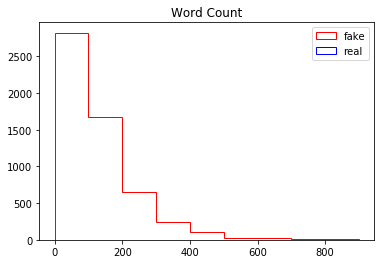

In [5]:
b=np.arange(0,1000,100)
plt.figure()
plt.hist(training['word_count'][training.label==1],b,histtype='step',color='r',label='fake')
plt.hist(training['word_count'][training.label==0],b,histtype='step',color='b',label='real')
plt.legend()
plt.title('Word Count')
plt.savefig('Wordcount.png')

In [6]:
training.label[training.label==1]=0
testing.label[testing.label==1]=0
training.label[training.label==-1]=1
testing.label[testing.label==-1]=1
id_train=np.random.permutation(len(testing))
id_test=np.random.permutation(len(training))
new_testing=testing.iloc[id_train]
new_training=training.iloc[id_test]
training=new_training
testing=new_testing
valid_y=testing.label
train_y=training.label

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doi

In [7]:
# reviewer_centric features #
#training.user_id.value_counts()

training['date.1'] = pd.to_datetime(training['date.1'])
training['day_of_week'] = training['date.1'].dt.day_name()
#training.day_of_week.value_counts()[:10]]
dofw = training.day_of_week.unique()
for day in range(len(dofw)):
        label=training['label'][training.day_of_week == dofw[day]]
        fake=len(label[label==1])
        real=len(label[label==0])
        
        print("***********Day is ",dofw[day])
        print("fake is ",fake)
        print("real is ",real)
        print("tot is ",fake+real)
        print("Ratio is ",100*(fake/(fake+real)))
        print("len is ",len(label))

training['user_id_no_of_review'] = training.groupby('user_id')['user_id'].transform('size')
training['user_id_ave_rating'] = training.groupby('user_id')['rating'].transform('mean')
#training['user_id_std_rating'] = training.groupby('user_id')['rating'].transform('std')
training['user_id_ave_no_words'] = training.groupby('user_id')['word_count'].transform('mean')
training['user_id_max_review_a_day'] = training['user_id_no_of_review']
grouped = training.groupby('user_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    training.loc[training.user_id == name,'user_id_max_review_a_day'] = df2
    #group['user_id_max_review_a_day']=df2

#training[:][training.user_id==9236].sort_index(axis = 0)
    
testing['date.1'] = pd.to_datetime(testing['date.1'])
testing['day_of_week'] = testing['date.1'].dt.day_name()
#testing.day_of_week.value_counts()[:10]]
dofw = testing.day_of_week.unique()
for day in range(len(dofw)):
        label=testing['label'][testing.day_of_week == dofw[day]]
        fake=len(label[label==1])
        real=len(label[label==0])
        

testing['user_id_no_of_review'] = testing.groupby('user_id')['user_id'].transform('size')
testing['user_id_ave_rating'] = testing.groupby('user_id')['rating'].transform('mean')
#testing['user_id_std_rating'] = testing.groupby('user_id')['rating'].transform('std')
testing['user_id_ave_no_words'] = testing.groupby('user_id')['word_count'].transform('mean')
testing['user_id_max_review_a_day'] = testing['user_id_no_of_review']
grouped = testing.groupby('user_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    testing.loc[testing.user_id == name,'user_id_max_review_a_day'] = df2
    #group['user_id_max_review_a_day']=df2

#testing[:][testing.user_id==9236].sort_index(axis = 0)    

***********Day is  Friday
fake is  758
real is  701
tot is  1459
Ratio is  51.953392734749826
len is  1459
***********Day is  Tuesday
fake is  800
real is  788
tot is  1588
Ratio is  50.377833753148614
len is  1588
***********Day is  Wednesday
fake is  836
real is  758
tot is  1594
Ratio is  52.446675031367626
len is  1594
***********Day is  Saturday
fake is  756
real is  744
tot is  1500
Ratio is  50.4
len is  1500
***********Day is  Sunday
fake is  790
real is  903
tot is  1693
Ratio is  46.66272888363851
len is  1693
***********Day is  Thursday
fake is  764
real is  755
tot is  1519
Ratio is  50.29624753127058
len is  1519
***********Day is  Monday
fake is  858
real is  913
tot is  1771
Ratio is  48.4472049689441
len is  1771


In [8]:
# product_centric features #
#training.prod_id.value_counts()

training['prod_id_no_of_review'] = training.groupby('prod_id')['prod_id'].transform('size') 
training['prod_id_ave_rating'] = training.groupby('prod_id')['rating'].transform('mean')
#training['prod_id_std_rating'] = training.groupby('prod_id')['rating'].transform('std')
training['prod_id_ave_no_words'] = training.groupby('prod_id')['word_count'].transform('mean')
training['prod_id_max_review_a_day'] = training['prod_id_no_of_review']
grouped = training.groupby('prod_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    training.loc[training.prod_id == name,'prod_id_max_review_a_day'] = df2
    #group['prod_id_max_review_a_day']=df2

#training[:][training.prod_id==247].sort_index(axis = 0)

testing['prod_id_no_of_review'] = testing.groupby('prod_id')['prod_id'].transform('size')
testing['prod_id_ave_rating'] = testing.groupby('prod_id')['rating'].transform('mean')
#testing['prod_id_std_rating'] = testing.groupby('prod_id')['rating'].transform('std')
testing['prod_id_ave_no_words'] = testing.groupby('prod_id')['word_count'].transform('mean')
testing['prod_id_max_review_a_day'] = testing['prod_id_no_of_review']
grouped = testing.groupby('prod_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    testing.loc[testing.prod_id == name,'prod_id_max_review_a_day'] = df2
    #group['prod_id_max_review_a_day']=df2


training[:][training.prod_id==247].sort_index(axis = 0)

,user_id,prod_id,date.1,review,label,rating,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,day_of_week,user_id_no_of_review,user_id_ave_rating,user_id_ave_no_words,user_id_max_review_a_day,prod_id_no_of_review,prod_id_ave_rating,prod_id_ave_no_words,prod_id_max_review_a_day
date,,,,,,,,,,,,,,,,,,,,,
2011-01-02,89977,247,2011-01-02,"Coming from the Bay area where we do have some good ramen places, I unfortunately wasn't so impressed with the ramen here. The noodle (thinner and finer than most ramen places) was fresh but I prefer the more traditional size and texture. The broth was good but it didnt knock my socks off. I think Dojo/Santa/Maru in the Bay area probably compare better on taste and depth of flavor. That said, I wasn't dying of thirst afterwards (no MSG?) We ordered appetizer of Samurai Rib, Bakuretsu Tofu and Hirata Bun. Of the three, I liked the Samurai Rib the most. Bakuretsu Tofu is cute. Like Korean jigae but a little out of place as it competes with the ramen if you plan to have ramen. The Hirata bun wasn't too special. Momofuku's pork buns are probably better (from what I recall). It gets stars for the vibe, decor, and service. Net net ... I dont think I would wait in line to pay $14 for ramen again.",0,3.0,902,167,5.369048,35,33,9,Sunday,1,3.000000,167.000000,1,235,4.042553,118.948936,4
2011-01-05,157513,247,2011-01-05,"Whenever I have friends in own, this is one of the placed I take them to. It makes you feel so welcome when the servers all say something in Japanese when you walk into the main dining room, and then again when you leave. Must haves: pork buns and all of the ramen dishes are good, ask for their special spicy sauce to put in the ramen. YUM",1,4.0,340,68,4.927536,7,6,3,Wednesday,1,4.000000,68.000000,1,235,4.042553,118.948936,4
2011-01-05,94310,247,2011-01-05,"This ain't no hole in the wall ramen spot. This is upscale! I went solo but once I walked in the place was PACKED! Great atmosphere and very friendly employees. I was really impressed with how great the place looked and how well the servers were treating everyone, including myself. I was told 15 minute wait so I walked outside because of the crowd inside and not even 2 minutes later someone came out and called my name, guess I got lucky. I had just before that got donuts from the Doughnut Plant and had my bag, the girl said that they dont allow outside food but courteously told me I can bring it in just dont show it off. All the service was very quick and I never had an empty cup. This place is just on par with daikakuya in L.A. but better because for the ambiance and courteous/speedy service. As far as straight ramen is concern it's still no match for Santouka. It's a bit pricey, because ramen shouldn't ever be more than $10 but hey, its New York right?",0,4.0,970,183,5.271739,24,21,11,Wednesday,1,4.000000,183.000000,1,235,4.042553,118.948936,4
2011-01-09,22455,247,2011-01-09,"Joining a league of thousands...I am adding my review to the sea of others to add to the hype that is Ippudo. We arrived early (for brunch standards) and only had to wait about 15-20 mns and even had some bench space. We did have to share our table (communal) but that's ok. It's large/wide enough to accomodate several parties at once. The only thing is you end up next to those with you and not across from them. So unless you're going w. a large group, be ready to share space. *Yamitsuki Goma Kyuri (Japanese cucumber mixed with sesami oil dressing): this we got from seeing a high recommendation on a friend's yelp. Wow. This was amazingly good and wondrously addicting. I mean how do they keep the cucumber so crisp? How is the sauce so light yet packs such flavor? How do I recreate this delicious and yet so simple dish?? After we finished I wished we had ordered 2 or 3. Next time... *Hirata Buns (Steamed buns filled w. pork and served w. Ippudo original spicy buns sauce): t...",0,4.0,2092,369,5.654054,85,46,4,Sunday,1,4.00000

In [9]:
final_testing=pd.read_csv('drive/My Drive/Project/final_testing.csv',header=0,index_col=0)
final_testing['char_count'] = final_testing['review'].apply(len)
final_testing['word_count'] = final_testing['review'].apply(lambda x: len(x.split()))
final_testing['word_density'] = final_testing['char_count'] / (final_testing['word_count']+1)
final_testing['punctuation_count'] = final_testing['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
final_testing['title_word_count'] = final_testing['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
final_testing['upper_case_word_count'] = final_testing['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
final_testing.label[final_testing.label==1]=0
final_testing.label[final_testing.label==-1]=1
id_test=np.random.permutation(len(final_testing))
final_testing=final_testing.iloc[id_test]
test_y=final_testing.label

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
final_testing['date.1'] = pd.to_datetime(final_testing['date.1'])
final_testing['day_of_week'] = final_testing['date.1'].dt.day_name()
#testing.day_of_week.value_counts()[:10]]
dofw = final_testing.day_of_week.unique()
for day in range(len(dofw)):
        label=final_testing['label'][final_testing.day_of_week == dofw[day]]
        fake=len(label[label==1])
        real=len(label[label==0])
        

final_testing['user_id_no_of_review'] = final_testing.groupby('user_id')['user_id'].transform('size')
final_testing['user_id_ave_rating'] = final_testing.groupby('user_id')['rating'].transform('mean')
#testing['user_id_std_rating'] = testing.groupby('user_id')['rating'].transform('std')
final_testing['user_id_ave_no_words'] = final_testing.groupby('user_id')['word_count'].transform('mean')
final_testing['user_id_max_review_a_day'] = final_testing['user_id_no_of_review']
grouped = final_testing.groupby('user_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    final_testing.loc[final_testing.user_id == name,'user_id_max_review_a_day'] = df2
    #group['user_id_max_review_a_day']=df2

#testing[:][testing.user_id==9236].sort_index(axis = 0)    

In [0]:
#training[:][training.prod_id==247].sort_index(axis = 0)

final_testing['prod_id_no_of_review'] = final_testing.groupby('prod_id')['prod_id'].transform('size')
final_testing['prod_id_ave_rating'] = final_testing.groupby('prod_id')['rating'].transform('mean')
#testing['prod_id_std_rating'] = testing.groupby('prod_id')['rating'].transform('std')
final_testing['prod_id_ave_no_words'] = final_testing.groupby('prod_id')['word_count'].transform('mean')
final_testing['prod_id_max_review_a_day'] = final_testing['prod_id_no_of_review']
grouped = testing.groupby('prod_id')

for name,group in grouped:
    #print(name)
    #print(group)
    df2 = group.groupby('date').size().max()
    #print(df2)
    final_testing.loc[final_testing.prod_id == name,'prod_id_max_review_a_day'] = df2
    #group['prod_id_max_review_a_day']=df2


In [0]:
from numpy import hstack
def add_features(feature_vector_train, feature_vector_valid,feature_vector_test):
    
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['prod_id']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['rating']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['user_id_no_of_review']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['user_id_ave_rating']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['user_id_ave_no_words']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['user_id_max_review_a_day']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['prod_id_no_of_review']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['prod_id_ave_rating']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['prod_id_ave_no_words']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['prod_id_max_review_a_day']))[:,None]))    
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['char_count']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['word_count']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['word_density']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['punctuation_count']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['title_word_count']))[:,None]))
    feature_vector_train = hstack((feature_vector_train,np.array(minmax_scale(training['upper_case_word_count']))[:,None]))
    
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['prod_id']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['rating']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['user_id_no_of_review']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['user_id_ave_rating']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['user_id_ave_no_words']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['user_id_max_review_a_day']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['prod_id_no_of_review']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['prod_id_ave_rating']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['prod_id_ave_no_words']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['prod_id_max_review_a_day']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['char_count']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['word_count']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['word_density']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['punctuation_count']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['title_word_count']))[:,None]))
    feature_vector_valid = hstack((feature_vector_valid,np.array(minmax_scale(testing['upper_case_word_count']))[:,None]))
    
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['prod_id']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['rating']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['user_id_no_of_review']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['user_id_ave_rating']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['user_id_ave_no_words']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['user_id_max_review_a_day']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['prod_id_no_of_review']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['prod_id_ave_rating']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['prod_id_ave_no_words']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['prod_id_max_review_a_day']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['char_count']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['word_count']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['word_density']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['punctuation_count']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['title_word_count']))[:,None]))
    feature_vector_test = hstack((feature_vector_test,np.array(minmax_scale(final_testing['upper_case_word_count']))[:,None]))
    
    return [feature_vector_train, feature_vector_valid, feature_vector_test]

In [0]:
from sklearn.preprocessing import minmax_scale
train_feat=(np.array(minmax_scale([training['user_id']],axis=1)))
valid_feat=(np.array(minmax_scale([testing['user_id']],axis=1)))
test_feat=(np.array(minmax_scale([final_testing['user_id']],axis=1)))

In [14]:
train_feat.T.shape

(11124, 1)

In [0]:
[train_feat,valid_feat,test_feat]=add_features(train_feat.T,valid_feat.T,test_feat.T)

In [16]:
train_feat.shape

(11124, 17)

In [17]:
test_feat.shape

(10000, 17)

In [0]:
embeddings_index = {}
f = open('drive/My Drive/Project/glove.6B.100d.txt',encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [19]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
maxlen = np.max(training['word_count']) # max number of words in a question to use
#maxlen=300
token = text.Tokenizer()
token.fit_on_texts(training.review)
word_index = token.word_index
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(training.review), maxlen=maxlen)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(testing.review), maxlen=maxlen)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(final_testing.review), maxlen=maxlen)
train_y=training.label
valid_y=testing.label
test_y=final_testing.label

In [0]:
# config values
embed_size = 100 # how big is each word vector
max_features = len(word_index) # how many unique words to use (i.e num rows in embedding vector)


In [0]:
#GLOVE
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
max=200
feat=1000
count_vect_2 = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1),stop_words="english")
count_vect_2.fit(training.review)
pos=count_vect_2.transform(training.review[training.label==1])
neg=count_vect_2.transform(training.review[training.label==0])
val=(neg.sum(axis=0)-pos.sum(axis=0))
ind_2=np.squeeze(np.asarray(val)).argsort()[-feat:][::-1]
va_1l=(pos.sum(axis=0)-neg.sum(axis=0))
ind_1=np.squeeze(np.asarray(va_1l)).argsort()[-feat:][::-1]
ind=np.concatenate((ind_1,ind_2))
voc=np.array(count_vect_2.get_feature_names())
vocab=dict(np.ndenumerate(voc[ind]))
xtrain_count=count_vect_2.transform(training.review)
xtrain_count=xtrain_count[:,ind]
xvalid_count=count_vect_2.transform(testing.review)
xvalid_count=xvalid_count[:,ind]
xtest_count=count_vect_2.transform(final_testing.review)
xtest_count=xtest_count[:,ind]

In [0]:
count_vect_1 = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,2), stop_words="english" )
count_vect_1.fit(training.review)
pos=count_vect_1.transform(training.review[training.label==1])
neg=count_vect_1.transform(training.review[training.label==0])
val=(neg.sum(axis=0)-pos.sum(axis=0))
ind_2=np.squeeze(np.asarray(val)).argsort()[-feat:][::-1]
va_1l=(pos.sum(axis=0)-neg.sum(axis=0))
ind_1=np.squeeze(np.asarray(va_1l)).argsort()[-feat:][::-1]
ind=np.concatenate((ind_1,ind_2))
voc=np.array(count_vect_1.get_feature_names())
vocab=dict(np.ndenumerate(voc[ind]))
xtrain_count_1=count_vect_1.transform(training.review)
xtrain_count_1=xtrain_count_1[:,ind]
xvalid_count_1=count_vect_1.transform(testing.review)
xvalid_count_1=xvalid_count_1[:,ind]
xtest_count_1=count_vect_1.transform(final_testing.review)
xtest_count_1=xtest_count_1[:,ind]

In [0]:
bigrams=[]
for key, value in count_vect_1.vocabulary_.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if value in ind:
        bigrams.append(key)

In [0]:
#unigrams=[]
for key, value in count_vect_2.vocabulary_.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if value in ind:
        bigrams.append(key)

In [0]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [0]:
maskArray = np.array(Image.open("cloud.png"))
cloud = WordCloud(background_color = "white", max_words = 200, mask = maskArray, stopwords = set(STOPWORDS))
cloud.generate(' '.join(word for word in unigrams))
cloud.to_file("uni_cloud.png")

In [0]:
maskArray = np.array(Image.open("cloud.png"))
cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS))
cloud.generate(' '.join(word for word in bigrams))
cloud.to_file("bi_uni_cloud.png")

In [0]:
len(unigrams)

2000

In [0]:
import scipy
xtrain_count_final=scipy.sparse.hstack((xtrain_count,xtrain_count_1))
xvalid_count_final=scipy.sparse.hstack((xvalid_count,xvalid_count_1))
xtest_count_final=scipy.sparse.hstack((xtest_count,xtest_count_1))

In [0]:
train_y=training.label
valid_y=testing.label
test_y=final_testing.label
train_x=xtrain_count_final
valid_x=xvalid_count_final
test_x=xtest_count_final

In [0]:
from keras.utils import to_categorical
train_y=to_categorical(train_y)
test_y=to_categorical(test_y)
valid_y=to_categorical(valid_y)

In [0]:
from keras.callbacks import ModelCheckpoint
import keras

In [0]:
#@title Working Neural Network


In [0]:
#def create_model_architecture(init_mode='uniform',dropout_rate=0.0,activation='relu',optimizer='Adam'):
activation='relu'
optimizer='Adam'
dropout_rate=0
l=0.01
# create input layer 
input_layer = layers.Input((train_x.shape[1], ), )
input_layer_1 = layers.Dropout(0)(input_layer)
# create hidden layer
hidden_layer_1 = layers.Dense(1000, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(input_layer_1)
hidden_layer_1 = layers.Dropout(dropout_rate)(hidden_layer_1)
hidden_layer_2 = layers.Dense(1000, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_1)
hidden_layer_2 = layers.Dropout(dropout_rate)(hidden_layer_2)
hidden_layer_3 = layers.Dense(400, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_2)
hidden_layer_3 = layers.Dropout(dropout_rate)(hidden_layer_3)


# create hidden layer
input_layer_2 = layers.Input(shape=(train_feat.shape[1], ), )
input_layer_3 = layers.Dropout(0)(input_layer_2)
hidden_layer_4 = layers.Dense(10, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(input_layer_3)
hidden_layer_4 = layers.Dropout(dropout_rate)(hidden_layer_4)
hidden_layer_5 = layers.Dense(10, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_4)
hidden_layer_5 = layers.Dropout(dropout_rate)(hidden_layer_5)
hidden_layer_6 = layers.Dense(5, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_5)
hidden_layer_6 = layers.Dropout(dropout_rate)(hidden_layer_6)

#concatenate
combined=layers.concatenate([hidden_layer_3, hidden_layer_6],axis=1)
combined=layers.Dropout(0.5)(combined)
# create output layer
z = layers.Dense(2, activation="relu")(combined)
z = layers.Dense(2, activation="softmax")(z)

classifier = models.Model(inputs = [input_layer,input_layer_2], outputs = z)
checkpoint = ModelCheckpoint('nn_tfidf.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    #return classifier 

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
#classifier = create_model_architecture()
import random
random.seed(0)
np.random.seed(0)

In [0]:
classifier.fit([train_x.toarray(),train_feat], train_y, batch_size=64, epochs=20, callbacks=[checkpoint],validation_data=([valid_x.toarray(),valid_feat],valid_y), shuffle=True, validation_freq=1)

Train on 11124 samples, validate on 2000 samples
Epoch 1/20
11124/11124 [==============================] - 2s 214us/step - loss: 0.6180 - acc: 0.6992 - val_loss: 0.6166 - val_acc: 0.7035

Epoch 00001: val_acc did not improve from 0.70400
Epoch 2/20
11124/11124 [==============================] - 2s 213us/step - loss: 0.6189 - acc: 0.6962 - val_loss: 0.6224 - val_acc: 0.6900

Epoch 00002: val_acc did not improve from 0.70400
Epoch 3/20
11124/11124 [==============================] - 2s 212us/step - loss: 0.6120 - acc: 0.7005 - val_loss: 0.6115 - val_acc: 0.7020

Epoch 00003: val_acc did not improve from 0.70400
Epoch 4/20
11124/11124 [==============================] - 2s 211us/step - loss: 0.6150 - acc: 0.6995 - val_loss: 0.6236 - val_acc: 0.6885

Epoch 00004: val_acc did not improve from 0.70400
Epoch 5/20
11124/11124 [==============================] - 2s 211us/step - loss: 0.6119 - acc: 0.7014 - val_loss: 0.6225 - val_acc: 0.6860

Epoch 00005: val_acc did not improve from 0.70400
Epoch 

In [32]:
ls

drive/  sample_data/  Wordcount.png


In [33]:
#def create_model_architecture(init_mode='uniform',dropout_rate=0.0,activation='relu',optimizer='Adam'):
activation='relu'
optimizer='Adam'
dropout_rate=0
l=0.01
# create input layer 
input_layer = layers.Input((train_x.shape[1], ), )
input_layer_1 = layers.Dropout(0)(input_layer)
# create hidden layer
hidden_layer_1 = layers.Dense(1000, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(input_layer_1)
hidden_layer_1 = layers.Dropout(dropout_rate)(hidden_layer_1)
hidden_layer_2 = layers.Dense(1000, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_1)
hidden_layer_2 = layers.Dropout(dropout_rate)(hidden_layer_2)
hidden_layer_3 = layers.Dense(400, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_2)
hidden_layer_3 = layers.Dropout(dropout_rate)(hidden_layer_3)


# create hidden layer
input_layer_2 = layers.Input(shape=(train_feat.shape[1], ), )
input_layer_3 = layers.Dropout(0)(input_layer_2)
hidden_layer_4 = layers.Dense(10, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(input_layer_3)
hidden_layer_4 = layers.Dropout(dropout_rate)(hidden_layer_4)
hidden_layer_5 = layers.Dense(10, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_4)
hidden_layer_5 = layers.Dropout(dropout_rate)(hidden_layer_5)
hidden_layer_6 = layers.Dense(5, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_5)
hidden_layer_6 = layers.Dropout(dropout_rate)(hidden_layer_6)

#concatenate
combined=layers.concatenate([hidden_layer_3, hidden_layer_6],axis=1)
combined=layers.Dropout(0.5)(combined)
# create output layer
z = layers.Dense(2, activation="relu")(combined)
z = layers.Dense(2, activation="softmax")(z)

classifier = models.Model(inputs = [input_layer,input_layer_2], outputs = z)
#checkpoint = ModelCheckpoint('nn_tfidf.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
classifier.load_weights("drive/My Drive/Project/Weights/nn_tfidf.hdf5")
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    #return classifier 
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
#classifier = create_model_architecture()
import random
random.seed(0)
np.random.seed(0)

In [36]:
print("Training NN with features")
output_valid=classifier.predict([train_x.toarray(),train_feat])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(training.label,final))
probs=output_valid[:,1]
get_metrics(training.label,output_valid,final,"NN with features")

Training NN with features
Accuracy for NN with features is  0.7337288745055736
Auc ROC for  NN with features  is  0.8052335342782309
Auc PRC for  NN with features  is  0.7812768713539049
F1 score for  NN with features  is  0.753084361453818
Log loss for  NN with features  is  0.5557807607871622


In [37]:
print("Validation NN with features")
output_valid=classifier.predict([valid_x.toarray(),valid_feat])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(testing.label,final))
probs=output_valid[:,1]
get_metrics(testing.label,output_valid,final,"NN with features")

Validation NN with features
Accuracy for NN with features is  0.704
Auc ROC for  NN with features  is  0.760423
Auc PRC for  NN with features  is  0.7174110360275023
F1 score for  NN with features  is  0.7013118062563067
Log loss for  NN with features  is  0.588031388733536


In [46]:
print("Test NN with features")
output_valid=classifier.predict([test_x.toarray(),test_feat])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(final_testing.label,final))
probs=output_valid[:,1]
get_metrics(final_testing.label,output_valid,final,"NN with features")

Test NN with features
Accuracy for NN with features is  0.6911
Auc ROC for  NN with features  is  0.74737712
Auc PRC for  NN with features  is  0.7100880287551287
F1 score for  NN with features  is  0.7257391458758767
Log loss for  NN with features  is  0.5978206346869469


In [0]:
nn=output_valid

In [0]:
from sklearn.utils import resample
from scipy import stats
n=50
acc=np.zeros(n)
for i in range(n):
  ind = resample(np.arange(len(final_testing.label)),replace=False,n_samples=2000)
  output_valid=classifier.predict([test_x.toarray()[ind],test_feat[ind]])
  final=np.argmax(output_valid,axis=1)
  acc[i]=sklearn.metrics.accuracy_score(final_testing.label[ind],final)
print(stats.describe(acc))
print("Std error is ",np.std(acc))

DescribeResult(nobs=50, minmax=(0.669, 0.715), mean=0.69113, variance=0.00011180418367346911, skewness=0.03318396340144469, kurtosis=-0.3719489973565091)
Std error is  0.010467478206330297


In [0]:
#@title NN without features

In [0]:
#def create_model_architecture(init_mode='uniform',dropout_rate=0.0,activation='relu',optimizer='Adam'):
activation='relu'
optimizer='Adam'
dropout_rate=0
l=0.005
# create input layer 
input_layer = layers.Input((train_x.shape[1], ), )
input_layer_1 = layers.Dropout(0)(input_layer)
# create hidden layer
hidden_layer_1 = layers.Dense(1000, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(input_layer_1)
hidden_layer_1 = layers.Dropout(dropout_rate)(hidden_layer_1)
hidden_layer_2 = layers.Dense(1000, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_1)
hidden_layer_2 = layers.Dropout(dropout_rate)(hidden_layer_2)
hidden_layer_3 = layers.Dense(400, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_2)
hidden_layer_3 = layers.Dropout(dropout_rate)(hidden_layer_3)



# create output layer
z = layers.Dense(2, activation="softmax")(hidden_layer_3)

classifier = models.Model(inputs = [input_layer], outputs = z)
checkpoint = ModelCheckpoint('nn_tfidf_withoutfeatures.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    #return classifier 
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
#classifier = create_model_architecture()
import random
random.seed(0)
np.random.seed(0)

In [0]:
classifier.fit([train_x.toarray()], train_y, batch_size=1500, epochs=20, callbacks=[checkpoint],validation_data=([valid_x.toarray()],valid_y), shuffle=True, validation_freq=1)

Train on 11124 samples, validate on 2000 samples
Epoch 1/20
11124/11124 [==============================] - 3s 230us/step - loss: 13.4446 - acc: 0.5090 - val_loss: 9.4877 - val_acc: 0.5075

Epoch 00001: val_acc improved from -inf to 0.50750, saving model to nn_tfidf_withoutfeatures.hdf5
Epoch 2/20
11124/11124 [==============================] - 0s 43us/step - loss: 7.5695 - acc: 0.5376 - val_loss: 5.2353 - val_acc: 0.5330

Epoch 00002: val_acc improved from 0.50750 to 0.53300, saving model to nn_tfidf_withoutfeatures.hdf5
Epoch 3/20
11124/11124 [==============================] - 0s 43us/step - loss: 4.1830 - acc: 0.5774 - val_loss: 2.9437 - val_acc: 0.6490

Epoch 00003: val_acc improved from 0.53300 to 0.64900, saving model to nn_tfidf_withoutfeatures.hdf5
Epoch 4/20
11124/11124 [==============================] - 0s 44us/step - loss: 2.4136 - acc: 0.6309 - val_loss: 1.8018 - val_acc: 0.6585

Epoch 00004: val_acc improved from 0.64900 to 0.65850, saving model to nn_tfidf_withoutfeatures.h

In [0]:
#def create_model_architecture(init_mode='uniform',dropout_rate=0.0,activation='relu',optimizer='Adam'):
activation='relu'
optimizer='Adam'
dropout_rate=0
l=0.005
# create input layer 
input_layer = layers.Input((train_x.shape[1], ), )
input_layer_1 = layers.Dropout(0)(input_layer)
# create hidden layer
hidden_layer_1 = layers.Dense(1000, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(input_layer_1)
hidden_layer_1 = layers.Dropout(dropout_rate)(hidden_layer_1)
hidden_layer_2 = layers.Dense(1000, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_1)
hidden_layer_2 = layers.Dropout(dropout_rate)(hidden_layer_2)
hidden_layer_3 = layers.Dense(400, activation=activation,kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_2)
hidden_layer_3 = layers.Dropout(dropout_rate)(hidden_layer_3)



# create output layer
z = layers.Dense(2, activation="softmax")(hidden_layer_3)

classifier = models.Model(inputs = [input_layer], outputs = z)
#checkpoint = ModelCheckpoint('nn_tfidf_withoutfeatures.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
classifier.load_weights('nn_tfidf_withoutfeatures.hdf5')
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    #return classifier 
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
#classifier = create_model_architecture()
import random
random.seed(0)
np.random.seed(0)

In [0]:
print("Training NN without features")
output_valid=classifier.predict([train_x.toarray()])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(training.label,final))
probs=output_valid[:,1]
get_metrics(training.label,output_valid,final,"NN without features")

Training NN without features
Accuracy for NN with features is  0.7015462064005753
Auc ROC for  NN without features  is  0.7703675225411661
Auc PRC for  NN without features  is  0.7488609229302696
F1 score for  NN without features  is  0.693952802359882
Log loss for  NN without features  is  0.5907195085731289


In [0]:
print("Validation NN without features")
output_valid=classifier.predict([valid_x.toarray()])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(testing.label,final))
probs=output_valid[:,1]
get_metrics(testing.label,output_valid,final,"NN with features")

print("Test NN without features")
output_valid=classifier.predict([test_x.toarray()])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(final_testing.label,final))
probs=output_valid[:,1]
get_metrics(final_testing.label,output_valid,final,"NN with features")

Validation NN without features
Accuracy for NN with features is  0.671
Auc ROC for  NN with features  is  0.7147015
Auc PRC for  NN with features  is  0.6781186156979242
F1 score for  NN with features  is  0.6706706706706708
Log loss for  NN with features  is  0.623694647282362
Test NN without features
Accuracy for NN with features is  0.6533
Auc ROC for  NN with features  is  0.7094781
Auc PRC for  NN with features  is  0.6835623619612535
F1 score for  NN with features  is  0.6578505871903682
Log loss for  NN with features  is  0.6242736344873905


In [0]:
from sklearn.utils import resample
from scipy import stats
n=50
acc=np.zeros(n)
for i in range(n):
  ind = resample(np.arange(len(final_testing.label)),replace=False,n_samples=2000)
  output_valid=classifier.predict([test_x.toarray()[ind]])
  final=np.argmax(output_valid,axis=1)
  acc[i]=sklearn.metrics.accuracy_score(final_testing.label[ind],final)
print(stats.describe(acc))
print("Std error is ",np.std(acc))

DescribeResult(nobs=50, minmax=(0.6265, 0.667), mean=0.6526099999999999, variance=7.83907142857145e-05, skewness=-0.9257478337779269, kurtosis=0.776773525140332)
Std error is  0.008764867369219012


In [0]:
import sys
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# filter sizes of the different conv layers 
filter_sizes = [1,2,3,4,5]
num_filters = 128
drop=0.5

In [0]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            embed_size,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)

In [0]:
inputs = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inputs)
l2=0.005
print(embedding.shape)
reshape = Reshape((maxlen,embed_size,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[4], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_4 = MaxPool2D(pool_size=(maxlen - filter_sizes[4] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=2, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights_cnn_sentece_1.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-3)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

(?, 915, 100)
(?, 915, 100, 1)
Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 915)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 915, 100)     2690800     input_45[0][0]                   
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 915, 100, 1)  0           embedding_1[3][0]                
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 915, 1, 128)  12928       reshape_4[0][0]                  
____________________________________________________________

In [0]:
random.seed(0)
np.random.seed(0)
track=model.fit([train_seq_x], train_y, batch_size=64, epochs=20, callbacks=[checkpoint],validation_data=([valid_seq_x],valid_y), shuffle=False, validation_freq=1)

Train on 11124 samples, validate on 2000 samples
Epoch 1/20
11124/11124 [==============================] - 8s 751us/step - loss: 0.6432 - acc: 0.6927 - val_loss: 0.6769 - val_acc: 0.6575

Epoch 00001: val_acc did not improve from 0.66700
Epoch 2/20
11124/11124 [==============================] - 8s 744us/step - loss: 0.6427 - acc: 0.6946 - val_loss: 0.6790 - val_acc: 0.6485

Epoch 00002: val_acc did not improve from 0.66700
Epoch 3/20
11124/11124 [==============================] - 8s 744us/step - loss: 0.6450 - acc: 0.6948 - val_loss: 0.6804 - val_acc: 0.6585

Epoch 00003: val_acc did not improve from 0.66700
Epoch 4/20
11124/11124 [==============================] - 8s 744us/step - loss: 0.6382 - acc: 0.7003 - val_loss: 0.6768 - val_acc: 0.6660

Epoch 00004: val_acc did not improve from 0.66700
Epoch 5/20
11124/11124 [==============================] - 8s 743us/step - loss: 0.6387 - acc: 0.6933 - val_loss: 0.6783 - val_acc: 0.6585

Epoch 00005: val_acc did not improve from 0.66700
Epoch 

In [49]:
inputs = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inputs)
l2=0.005
print(embedding.shape)
reshape = Reshape((maxlen,embed_size,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[4], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_4 = MaxPool2D(pool_size=(maxlen - filter_sizes[4] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=2, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

#checkpoint = ModelCheckpoint('weights_cnn_sentece_1.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
model.load_weights('weights_cnn_sentece_1.hdf5')
adam = Adam(lr=1e-3)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

(?, 915, 100)
(?, 915, 100, 1)


OSError: ignored

In [0]:
print("Training CNN without features")
output_valid=model.predict([train_seq_x])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(training.label,final))
probs=output_valid[:,1]
get_metrics(training.label,output_valid,final,"CNN without features")

Training CNN without features
Accuracy for NN with features is  0.7244696152463143
Auc ROC for  CNN without features  is  0.8013708790359817
Auc PRC for  CNN without features  is  0.7806295695556181
F1 score for  CNN without features  is  0.7155980328477312
Log loss for  CNN without features  is  0.5550451175603079


In [0]:
print("Validation CNN without features")
output_valid=model.predict([valid_seq_x])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(testing.label,final))
probs=output_valid[:,1]
get_metrics(testing.label,output_valid,final,"CNN without features")

print("Test CNN without features")
output_valid=model.predict([test_seq_x])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(final_testing.label,final))
probs=output_valid[:,1]
get_metrics(final_testing.label,output_valid,final,"CNN without features")

Validation CNN without features
Accuracy for NN with features is  0.667
Auc ROC for  CNN without features  is  0.720953
Auc PRC for  CNN without features  is  0.7039048998771226
F1 score for  CNN without features  is  0.6676646706586825
Log loss for  CNN without features  is  0.615776421573013
Test CNN without features
Accuracy for NN with features is  0.6482
Auc ROC for  CNN without features  is  0.70199632
Auc PRC for  CNN without features  is  0.6715253943337739
F1 score for  CNN without features  is  0.6583802680132066
Log loss for  CNN without features  is  0.627408957266435


In [0]:
from sklearn.utils import resample
from scipy import stats
n=50
acc=np.zeros(n)
for i in range(n):
  ind = resample(np.arange(len(final_testing.label)),replace=False,n_samples=2000)
  output_valid=model.predict([test_seq_x[ind]])
  final=np.argmax(output_valid,axis=1)
  acc[i]=sklearn.metrics.accuracy_score(final_testing.label[ind],final)
print(stats.describe(acc))
print("Std error is ",np.std(acc))

DescribeResult(nobs=50, minmax=(0.6205, 0.669), mean=0.6458099999999999, variance=9.069275510204082e-05, skewness=-0.1686570897157867, kurtosis=-0.044527514132542745)
Std error is  0.009427560660107153


In [57]:
inputs = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inputs)
l=0.005
print(embedding.shape)
reshape = Reshape((maxlen,embed_size,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[4], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_4 = MaxPool2D(pool_size=(maxlen - filter_sizes[4] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)


input_layer_2 = layers.Input(shape=(train_feat.shape[1], ), )
hidden_layer_4 = layers.Dense(20, activation='relu',kernel_regularizer=keras.regularizers.l2(l))(input_layer_2)
hidden_layer_4 = layers.Dropout(0)(hidden_layer_4)
hidden_layer_5 = layers.Dense(20, activation='relu',kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_4)
hidden_layer_5 = layers.Dropout(0)(hidden_layer_5)
hidden_layer_6 = layers.Dense(10, activation='relu',kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_5)
hidden_layer_6 = layers.Dropout(0)(hidden_layer_6)
combined=layers.concatenate([flatten, hidden_layer_6])
combined=layers.Dropout(0.5)(combined)
output = Dense(units=2, activation='softmax')(combined)

# this creates a model that includes
model = Model(inputs=[inputs,input_layer_2], outputs=output)

checkpoint = ModelCheckpoint('all_features_weights_cnn_sentece_1.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-3)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

(?, 915, 100)
(?, 915, 100, 1)


In [59]:
import random
random.seed(0)
np.random.seed(0)
track=model.fit([train_seq_x,train_feat], train_y, batch_size=64, epochs=20, callbacks=[checkpoint],validation_data=([valid_seq_x,valid_feat],valid_y), shuffle=False, validation_freq=1)

Train on 11124 samples, validate on 2000 samples
Epoch 1/20
11124/11124 [==============================] - 4s 390us/step - loss: 0.5837 - acc: 0.7487 - val_loss: 0.6291 - val_acc: 0.7205

Epoch 00001: val_acc did not improve from 0.72100
Epoch 2/20
11124/11124 [==============================] - 4s 386us/step - loss: 0.5811 - acc: 0.7522 - val_loss: 0.6307 - val_acc: 0.7150

Epoch 00002: val_acc did not improve from 0.72100
Epoch 3/20
11124/11124 [==============================] - 4s 385us/step - loss: 0.5843 - acc: 0.7455 - val_loss: 0.6351 - val_acc: 0.7150

Epoch 00003: val_acc did not improve from 0.72100
Epoch 4/20
11124/11124 [==============================] - 4s 386us/step - loss: 0.5804 - acc: 0.7507 - val_loss: 0.6305 - val_acc: 0.7195

Epoch 00004: val_acc did not improve from 0.72100
Epoch 5/20
11124/11124 [==============================] - 4s 387us/step - loss: 0.5771 - acc: 0.7567 - val_loss: 0.6333 - val_acc: 0.7175

Epoch 00005: val_acc did not improve from 0.72100
Epoch 

In [63]:
inputs = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inputs)
l=0.005
print(embedding.shape)
reshape = Reshape((maxlen,embed_size,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)
conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[4], embed_size), padding='valid', kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(l))(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_4 = MaxPool2D(pool_size=(maxlen - filter_sizes[4] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)


input_layer_2 = layers.Input(shape=(train_feat.shape[1], ), )
hidden_layer_4 = layers.Dense(20, activation='relu',kernel_regularizer=keras.regularizers.l2(l))(input_layer_2)
hidden_layer_4 = layers.Dropout(0)(hidden_layer_4)
hidden_layer_5 = layers.Dense(20, activation='relu',kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_4)
hidden_layer_5 = layers.Dropout(0)(hidden_layer_5)
hidden_layer_6 = layers.Dense(10, activation='relu',kernel_regularizer=keras.regularizers.l2(l))(hidden_layer_5)
hidden_layer_6 = layers.Dropout(0)(hidden_layer_6)
combined=layers.concatenate([flatten, hidden_layer_6])
combined=layers.Dropout(0.5)(combined)
output = Dense(units=2, activation='softmax')(combined)

# this creates a model that includes
model = Model(inputs=[inputs,input_layer_2], outputs=output)

#checkpoint = ModelCheckpoint('all_features_weights_cnn_sentece_1.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-3)
model.load_weights('drive/My Drive/Project/Weights/all_features_weights_cnn_sentece_1.hdf5')
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

(?, 915, 100)
(?, 915, 100, 1)


In [64]:
print("Training CNN with features")
output_valid=model.predict([train_seq_x,train_feat])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(training.label,final))
probs=output_valid[:,1]
get_metrics(training.label,output_valid,final,"CNN with features")

Training CNN with features
Accuracy for NN with features is  0.7306724199928083
Auc ROC for  CNN with features  is  0.8048323168425597
Auc PRC for  CNN with features  is  0.777069172213092
F1 score for  CNN with features  is  0.7500000000000001
Log loss for  CNN with features  is  0.5494885956369546


In [65]:
print("Validation CNN with features")
output_valid=model.predict([valid_seq_x,valid_feat])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(testing.label,final))
probs=output_valid[:,1]
get_metrics(testing.label,output_valid,final,"CNN with features")

print("Test CNN with features")
output_valid=model.predict([test_seq_x,test_feat])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(final_testing.label,final))
probs=output_valid[:,1]
get_metrics(final_testing.label,output_valid,final,"CNN with features")

Validation CNN with features
Accuracy for NN with features is  0.703
Auc ROC for  CNN with features  is  0.7670755
Auc PRC for  CNN with features  is  0.7335725479531572
F1 score for  CNN with features  is  0.711930164888458
Log loss for  CNN with features  is  0.5777193784918636
Test CNN with features
Accuracy for NN with features is  0.701
Auc ROC for  CNN with features  is  0.7569538800000001
Auc PRC for  CNN with features  is  0.71555483134366
F1 score for  CNN with features  is  0.7295586107091172
Log loss for  CNN with features  is  0.5871522069662809


In [0]:
cnn=output_valid

In [0]:
from sklearn.utils import resample
from scipy import stats
n=50
acc=np.zeros(n)
for i in range(n):
  ind = resample(np.arange(len(final_testing.label)),replace=False,n_samples=2000)
  output_valid=model.predict([test_seq_x[ind],test_feat[ind]])
  final=np.argmax(output_valid,axis=1)
  acc[i]=sklearn.metrics.accuracy_score(final_testing.label[ind],final)
print(stats.describe(acc))
print("Std error is ",np.std(acc))

DescribeResult(nobs=50, minmax=(0.685, 0.7295), mean=0.70872, variance=7.742000000000011e-05, skewness=0.03796349164282383, kurtosis=0.5320485099288184)

In [0]:
np.std(acc)

0.008710430528969283

In [0]:
from scipy import stats
stats.describe(acc)

DescribeResult(nobs=50, minmax=(0.691, 0.723), mean=0.7089300000000001, variance=4.502051020408165e-05, skewness=0.041077302452774175, kurtosis=0.14164053072029592)

In [0]:
print("Test CNN with features")
output_valid=model.predict([test_seq_x,test_feat])
final=np.argmax(output_valid,axis=1)
print("Accuracy for NN with features is ",sklearn.metrics.accuracy_score(final_testing.label,final))
probs=output_valid[:,1]
get_metrics(final_testing.label,output_valid,final,"NN with features")

Test CNN with features
Accuracy for NN with features is  0.7097
Auc ROC for  NN with features  is  0.7699329799999999
Auc PRC for  NN with features  is  0.7330093261666147
F1 score for  NN with features  is  0.7353450633603793
Log loss for  NN with features  is  0.5748459850158543


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
inputs = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((maxlen,embed_size,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[4], embed_size), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_4 = MaxPool2D(pool_size=(maxlen - filter_sizes[4] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)


input_layer_2 = layers.Input(shape=(train_feat.shape[1], ), )
hidden_layer_4 = layers.Dense(10, activation='relu',)(input_layer_2)
hidden_layer_4 = layers.Dropout(0)(hidden_layer_4)
hidden_layer_5 = layers.Dense(10, activation='relu',)(hidden_layer_4)
hidden_layer_5 = layers.Dropout(0)(hidden_layer_5)
hidden_layer_6 = layers.Dense(5, activation='relu',)(hidden_layer_5)
hidden_layer_6 = layers.Dropout(0)(hidden_layer_6)


# Add an Input Layer
input_layer = layers.Input((maxlen, ))

# Add the word embedding Layer
embedding_layer_lstm = layers.Embedding(len(word_index) + 1, embed_size, weights=[embedding_matrix], input_length=maxlen,trainable=False)(input_layer)
#embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

# Add the LSTM Layer
#lstm_layer = layers.LSTM(100)(embedding_layer)
lstm_layer=layers.Bidirectional(layers.LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(embedding_layer_lstm)
lstm_time=layers.TimeDistributed(layers.Dense(100,activation='relu'))(lstm_layer)
lstm_flat = layers.Flatten()(lstm_time)


combined=layers.concatenate([flatten, lstm_flat,hidden_layer_6])
combined=layers.Dropout(0.5)(combined)
output = Dense(units=2, activation='softmax')(combined)

# this creates a model that includes
model = Model(inputs=[inputs,input_layer,input_layer_2], outputs=output)

checkpoint = ModelCheckpoint('cnn_rnn_features_weights_cnn_sentece.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-3)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

(?, 915, 100)
(?, 915, 100, 1)
Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           (None, 915)          0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 915, 100)     2690800     input_69[0][0]                   
__________________________________________________________________________________________________
dense_93 (Dense)                (None, 10)           120         input_70[0][0]                   
____________________________________________________________

In [0]:
import random
random.seed(0)
np.random.seed(0)
track=model.fit([train_seq_x,train_seq_x,train_feat], train_y_cat, batch_size=64, epochs=20, callbacks=[checkpoint],validation_data=([valid_seq_x,valid_seq_x,test_feat],valid_y_cat), shuffle=False, validation_freq=1)

Train on 11124 samples, validate on 2000 samples
Epoch 1/20
11124/11124 [==============================] - 670s 60ms/step - loss: 0.6569 - acc: 0.6172 - val_loss: 0.6244 - val_acc: 0.6565

Epoch 00001: val_acc improved from -inf to 0.65650, saving model to cnn_rnn_features_weights_cnn_sentece.hdf5
Epoch 2/20
11124/11124 [==============================] - 665s 60ms/step - loss: 0.6006 - acc: 0.6797 - val_loss: 0.5938 - val_acc: 0.6815

Epoch 00002: val_acc improved from 0.65650 to 0.68150, saving model to cnn_rnn_features_weights_cnn_sentece.hdf5
Epoch 3/20
11124/11124 [==============================] - 657s 59ms/step - loss: 0.5725 - acc: 0.7060 - val_loss: 0.5912 - val_acc: 0.6805

Epoch 00003: val_acc did not improve from 0.68150
Epoch 4/20
11124/11124 [==============================] - 653s 59ms/step - loss: 0.5468 - acc: 0.7234 - val_loss: 0.5865 - val_acc: 0.6860

Epoch 00004: val_acc improved from 0.68150 to 0.68600, saving model to cnn_rnn_features_weights_cnn_sentece.hdf5
Epoch

KeyboardInterrupt: ignored

In [0]:
import os
import shutil

In [0]:
file=os.listdir()

In [0]:
os.mkdir('drive/My Drive/Project/Weights')

In [0]:
for i in range(len(file)):
  if file[i]!= "drive":
    shutil.move("content/"+file[i], "content/drive/My Drive/Project/"+file[i])

In [0]:
for i in range(len(file)):
  if file[i]!= ".config" and file[i]!="drive" and file[i]!="sample_data":
    shutil.copyfile(file[i], "drive/My Drive/Project/Weights/"+file[i])

In [0]:
file

['.config',
 'all_features_weights_cnn_sentece.hdf5',
 'weights_cnn_sentece.hdf5',
 'drive',
 'nn_tfidf_withoutfeatures.hdf5',
 'all_features_weights_cnn_sentece_1.hdf5',
 'weights_cnn_sentece_1.hdf5',
 'nn_tfidf.hdf5',
 'sample_data']

In [0]:
from sklearn import metrics

In [0]:
def get_metrics(y,probs_ll,predictions_ll,method):
  fpr_ll, tpr_ll, thresholds = metrics.roc_curve(y, probs_ll[:,1])
  auc_ll = metrics.roc_auc_score(y, probs_ll[:,1])
  print("Auc ROC for ",method," is ",auc_ll)
  precision_ll, recall_ll, thresholds = metrics.precision_recall_curve(y, probs_ll[:,1])
  auc_ll = metrics.auc(recall_ll, precision_ll)
  print("Auc PRC for ",method," is ",auc_ll)
  f1_ll = metrics.f1_score(y, predictions_ll)
  print("F1 score for ",method, " is ",f1_ll)
  print("Log loss for ",method," is ",metrics.log_loss(y,probs_ll[:,1]))

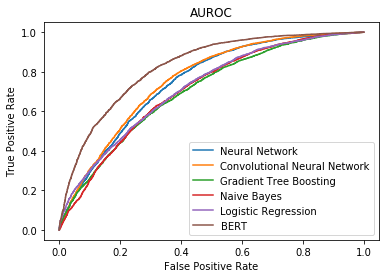

In [78]:
import matplotlib.pyplot as plt
fpr_nn, tpr_nn, thresholds = metrics.roc_curve(final_testing.label, nn[:,1])
fpr_cnn, tpr_cnn, thresholds = metrics.roc_curve(final_testing.label, cnn[:,1])
fpr_GB, tpr_GB, thresholds = metrics.roc_curve(GB.Label, GB.Probs)
fpr_NB, tpr_NB, thresholds = metrics.roc_curve(NB.labels, NB.prob)
fpr_LR, tpr_LR, thresholds = metrics.roc_curve(LR.labels, LR.prob)
fpr_BERT, tpr_BERT, thresholds = metrics.roc_curve(BERT.labels, BERT.prob)
# plot the roc curve for the model
#plt.plot(fpr, tpr, linestyle='--', label='NB')
plt.plot(fpr_nn, tpr_nn, linestyle='-', label='Neural Network')
plt.plot(fpr_cnn, tpr_cnn, linestyle='-', label='Convolutional Neural Network')
plt.plot(fpr_GB, tpr_GB, linestyle='-', label='Gradient Tree Boosting')
plt.plot(fpr_NB, tpr_NB, linestyle='-', label='Naive Bayes')
plt.plot(fpr_LR, tpr_LR, linestyle='-', label='Logistic Regression')
plt.plot(fpr_BERT, tpr_BERT, linestyle='-', label='BERT')
#pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('AUROC')
plt.savefig('AUROC.png')
# show the plot
plt.show()

In [0]:
from sklearn import calibration

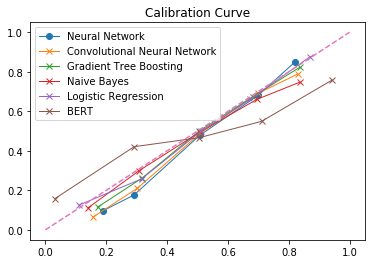

In [83]:
[y_nn,x_nn]=calibration.calibration_curve(final_testing.label,nn[:,1])
[y_cnn,x_cnn]=calibration.calibration_curve(final_testing.label,cnn[:,1])
[y_GB,x_GB]=calibration.calibration_curve(GB.Label,GB.Probs)
[y_NB,x_NB]=calibration.calibration_curve(NB.labels,NB.prob)
[y_LR,x_LR]=calibration.calibration_curve(LR.labels,LR.prob)
[y_BERT,x_BERT]=calibration.calibration_curve(BERT.labels,BERT.prob)
plt.plot(x_nn,y_nn, marker='o', linewidth=1, label='Neural Network')
plt.plot(x_cnn,y_cnn, marker='x', linewidth=1, label='Convolutional Neural Network')
plt.plot(x_GB,y_GB, marker='x', linewidth=1, label='Gradient Tree Boosting')
plt.plot(x_NB,y_NB, marker='x', linewidth=1, label='Naive Bayes')
plt.plot(x_LR,y_LR, marker='x', linewidth=1, label='Logistic Regression')
plt.plot(x_BERT,y_BERT, marker='x', linewidth=1, label='BERT')
x1=np.linspace(0,1,11)
y1=x1
plt.plot(x1,y1,linestyle='--')
plt.legend()
plt.title('Calibration Curve')
plt.savefig('CC.png')

In [0]:
GB=pd.read_csv('GB.csv')

In [99]:
GB.head()

,Unnamed: 0,Probs,Prediction,Label
0,0,0.626720,1,1
1,1,0.687280,1,0
2,2,0.745085,1,1
3,3,0.503105,1,0
4,4,0.789907,1,1


In [0]:
NB=pd.read_csv('NB.csv')
LR=pd.read_csv('LR.csv')
BERT=pd.read_csv('BERT.csv')

In [74]:
BERT.head()

,Unnamed: 0,prob,predictions,labels
0,0,0.967196,1,0
1,1,0.894302,1,1
2,2,0.980059,1,1
3,3,0.027559,0,0
4,4,0.231863,0,1


Accuracy: 0.6911
Precision: 0.6525626696471339
Recall: 0.8174


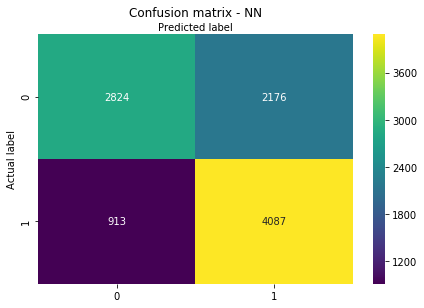

In [109]:

class_names=["True","False"]
cnf_matrix = metrics.confusion_matrix(final_testing.label, np.argmax(nn,axis=1))
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - NN', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy:",metrics.accuracy_score(final_testing.label, np.argmax(nn,axis=1)))
print("Precision:",metrics.precision_score(final_testing.label, np.argmax(nn,axis=1)))
print("Recall:",metrics.recall_score(final_testing.label, np.argmax(nn,axis=1)))
plt.savefig('NN_CC.png')

Accuracy: 0.701
Precision: 0.6659511228533685
Recall: 0.8066


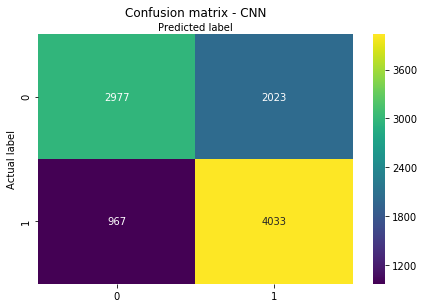

In [112]:

class_names=["True","False"]
cnf_matrix = metrics.confusion_matrix(final_testing.label, np.argmax(cnn,axis=1))
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - CNN', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy:",metrics.accuracy_score(final_testing.label, np.argmax(cnn,axis=1)))
print("Precision:",metrics.precision_score(final_testing.label, np.argmax(cnn,axis=1)))
print("Recall:",metrics.recall_score(final_testing.label, np.argmax(cnn,axis=1)))
plt.savefig('CNN_CC.png')

Accuracy: 0.6544
Precision: 0.632554945054945
Recall: 0.7368


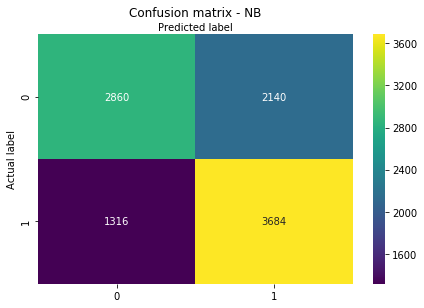

In [113]:
label=NB.labels
Predictions=NB.predictions
class_names=["True","False"]
cnf_matrix = metrics.confusion_matrix(label, Predictions)
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - NB', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy:",metrics.accuracy_score(label, Predictions))
print("Precision:",metrics.precision_score(label, Predictions))
print("Recall:",metrics.recall_score(label, Predictions))
plt.savefig('NB_CC.png')

Accuracy: 0.6564
Precision: 0.630812980930077
Recall: 0.7542


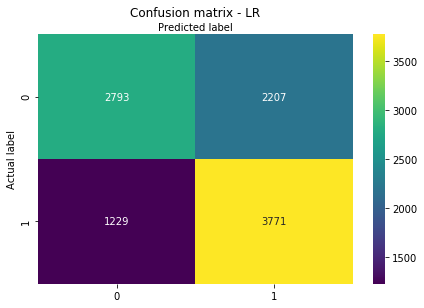

In [114]:
label=LR.labels
Predictions=LR.predictions
class_names=["True","False"]
cnf_matrix = metrics.confusion_matrix(label, Predictions)
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - LR', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy:",metrics.accuracy_score(label, Predictions))
print("Precision:",metrics.precision_score(label, Predictions))
print("Recall:",metrics.recall_score(label, Predictions))
plt.savefig('LR_CC.png')

Accuracy: 0.7505
Precision: 0.7163586111590948
Recall: 0.8294


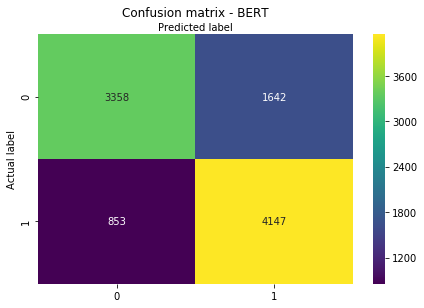

In [123]:
label=BERT.labels
Predictions=BERT.predictions
class_names=["True","False"]
cnf_matrix = metrics.confusion_matrix(label, Predictions)
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - BERT')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy:",metrics.accuracy_score(label, Predictions))
print("Precision:",metrics.precision_score(label, Predictions))
print("Recall:",metrics.recall_score(label, Predictions))
plt.savefig('BERT_CC.png')
plt.show()

Accuracy: 0.6448
Precision: 0.6287339971550497
Recall: 0.7072


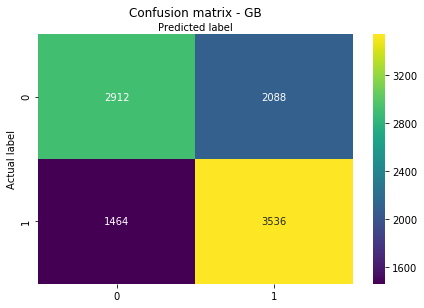

In [119]:
label=GB.Label
Predictions=GB.Prediction
class_names=["True","False"]
cnf_matrix = metrics.confusion_matrix(label, Predictions)
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - GB', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy:",metrics.accuracy_score(label, Predictions))
print("Precision:",metrics.precision_score(label, Predictions))
print("Recall:",metrics.recall_score(label, Predictions))
plt.savefig('GB_CC.png')

In [118]:
GB.head()

,Unnamed: 0,Probs,Prediction,Label
0,0,0.626720,1,1
1,1,0.687280,1,0
2,2,0.745085,1,1
3,3,0.503105,1,0
4,4,0.789907,1,1


In [87]:
np.argmax(nn,axis=1)

array([1, 1, 1, ..., 0, 1, 1])